# Análisis de Datos SQL en Jupyter Notebook
Este notebook contiene el análisis de datos utilizando **SQLite** y **Python**.

## Objetivos de la Prueba Técnica
1. Crear una base de datos SQL usando los archivos CSV proporcionados.
2. Crear las tablas necesarias y cargar los datos.
3. Identificar los jugadores que hicieron su primer depósito (FTD).
4. Filtrar aquellos que cumplen la condición de CPA (total de depósitos mayor a 100 USD).
5. Generar reportes de la cantidad de FTD por mes y de CPA por mes.

---

In [2]:
!pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 4.2 MB/s eta 0:00:000:00:010:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 4.2 MB/s eta 0:00:00m eta 0:00:010:00:01


In [3]:
import sqlite3
import pandas as pd

## 1. Cargar los Datos desde los Archivos CSV
En esta sección, cargamos los datos desde los archivos CSV en pandas.

In [4]:
players_df = pd.read_csv('./data/players.csv')
traffic_sources_df = pd.read_csv('./data/traffic_sources.csv')
deposits_df = pd.read_csv('./data/deposits.csv')
internal_records_df = pd.read_csv('./data/internal_records.csv')

# Mostrar las primeras filas de cada dataset
players_df.head(), traffic_sources_df.head(), deposits_df.head(), internal_records_df.head()

(                              player_id              name registration_date  \
 0  23b8c1e9-3924-46de-beb1-3b9046685257    Derek Anderson        2023-07-27   
 1  e465e150-bd9c-46b3-ad3c-2d6d1a3d1fa7  Michael Martinez        2023-02-28   
 2  0822e8f3-6c03-4199-972a-846916419f82     Cynthia Moore        2022-01-24   
 3  815ef6d1-3b8f-4a18-b7f8-a88b17fc695a      Jason Walker        2023-04-13   
 4  b74d0fb1-32e7-4629-8fad-c1a606cb0fb3      Julia Wilson        2023-05-20   
 
                 country  
 0                France  
 1                  Niue  
 2                Mexico  
 3            Tajikistan  
 4  Syrian Arab Republic  ,
                               player_id    trafficker  cost_of_acquisition  \
 0  23b8c1e9-3924-46de-beb1-3b9046685257  Trafficker_5               111.22   
 1  e465e150-bd9c-46b3-ad3c-2d6d1a3d1fa7  Trafficker_3               234.12   
 2  0822e8f3-6c03-4199-972a-846916419f82  Trafficker_9                71.73   
 3  815ef6d1-3b8f-4a18-b7f8-a88b17fc695

## 2. Crear Base de Datos y Tablas SQL
Creamos una base de datos en SQLite y definimos las tablas necesarias.

In [5]:
db_conn = sqlite3.connect("gaming_data.db")
cursor = db_conn.cursor()

cursor.executescript('''
    CREATE TABLE IF NOT EXISTS players (
        player_id INTEGER PRIMARY KEY,
        registration_date DATE
    );
    CREATE TABLE IF NOT EXISTS traffic_sources (
        player_id INTEGER,
        source TEXT,
        FOREIGN KEY (player_id) REFERENCES players(player_id)
    );
    CREATE TABLE IF NOT EXISTS deposits (
        deposit_id INTEGER PRIMARY KEY,
        player_id INTEGER,
        deposit_date DATE,
        amount REAL,
        FOREIGN KEY (player_id) REFERENCES players(player_id)
    );
    CREATE TABLE IF NOT EXISTS internal_records (
        player_id INTEGER PRIMARY KEY,
        status TEXT
    );
''')
db_conn.commit()
print("Base de datos y tablas creadas correctamente.")

Base de datos y tablas creadas correctamente.


## 3. Cargar Datos en la Base de Datos
Insertamos los datos de los DataFrames en las tablas SQLite.

In [6]:
players_df.to_sql("players", db_conn, if_exists="replace", index=False)
traffic_sources_df.to_sql("traffic_sources", db_conn, if_exists="replace", index=False)
deposits_df.to_sql("deposits", db_conn, if_exists="replace", index=False)
internal_records_df.to_sql("internal_records", db_conn, if_exists="replace", index=False)
print("Datos cargados exitosamente en SQLite.")

Datos cargados exitosamente en SQLite.


## 4. Identificar Primer Depósito (FTD)
Identificamos el primer depósito de cada jugador utilizando `MIN(deposit_date)`.

In [7]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS first_time_deposits AS
    SELECT player_id, MIN(deposit_date) AS first_deposit_date
    FROM deposits
    GROUP BY player_id;
''')
db_conn.commit()
print("Tabla de FTD creada correctamente.")

Tabla de FTD creada correctamente.


## 5. Filtrar Jugadores CPA (Depósitos > 100 USD)
Seleccionamos los jugadores que han depositado más de 100 USD en total.

In [9]:
cursor.execute('''
    CREATE TABLE IF NOT EXISTS cpa_players AS
    SELECT player_id, SUM(deposit_amount) AS total_deposits
    FROM deposits
    GROUP BY player_id
    HAVING total_deposits > 100;
''')
db_conn.commit()
print("Tabla de CPA creada correctamente.")

Tabla de CPA creada correctamente.


## 6. Reporte de FTD por Mes
Generamos un reporte de la cantidad de jugadores que hicieron su primer depósito cada mes.

In [10]:
ftd_report = pd.read_sql('''
    SELECT strftime('%Y-%m', first_deposit_date) AS month, COUNT(player_id) AS ftd_count
    FROM first_time_deposits
    GROUP BY month
    ORDER BY month;
''', db_conn)
print(ftd_report)

      month  ftd_count
0   2022-01          1
1   2022-03          4
2   2022-04          4
3   2022-05          3
4   2022-06          5
5   2022-07         11
6   2022-08          4
7   2022-09          9
8   2022-10          5
9   2022-11         13
10  2022-12          8
11  2023-01         16
12  2023-02          9
13  2023-03          8
14  2023-04         15
15  2023-05         14
16  2023-06         16
17  2023-07         13
18  2023-08         15
19  2023-09         21
20  2023-10         17
21  2023-11         26
22  2023-12         26


## 7. Reporte de CPA por Mes
Generamos un reporte de la cantidad de jugadores CPA (depósitos > 100 USD) cada mes.

In [11]:
cpa_report = pd.read_sql('''
    SELECT strftime('%Y-%m', deposit_date) AS month, COUNT(DISTINCT deposits.player_id) AS cpa_count
    FROM deposits
    JOIN cpa_players ON deposits.player_id = cpa_players.player_id
    GROUP BY month
    ORDER BY month;
''', db_conn)
print(cpa_report)

      month  cpa_count
0   2022-01          1
1   2022-03          5
2   2022-04          4
3   2022-05          4
4   2022-06          6
5   2022-07         14
6   2022-08          8
7   2022-09         14
8   2022-10          9
9   2022-11         20
10  2022-12         15
11  2023-01         23
12  2023-02         14
13  2023-03         20
14  2023-04         27
15  2023-05         23
16  2023-06         32
17  2023-07         26
18  2023-08         35
19  2023-09         41
20  2023-10         47
21  2023-11         66
22  2023-12         68



# Análisis de Calidad de Datos

Este notebook realiza un análisis de calidad de datos, comparando los resultados de **FTD** y **CPA** con los registros internos. 
Además, se analiza el histórico de depósitos y se identifican patrones clave en los datos.

## Pasos:
1. **Carga de datos**: Importación de archivos CSV.
2. **Comparación de FTD y CPA** con `internal_records.csv`.
3. **Detección de discrepancias** en los valores registrados.
4. **Visualización de discrepancias**.
5. **Análisis de depósitos**:
   - Histórico de dinero depositado.
   - Jugador que más ha depositado.
   - Distribución de depósitos por jugador.
   - Comparación de fuentes de tráfico.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Cargar los datos desde los archivos CSV
internal_records = pd.read_csv("./data/internal_records.csv")
players = pd.read_csv("./data/players.csv")
traffic_sources = pd.read_csv("./data/traffic_sources.csv")
deposits = pd.read_csv("./data/deposits.csv")

# Convertir fechas a formato datetime
internal_records["month"] = pd.to_datetime(internal_records["month"])
deposits["deposit_date"] = pd.to_datetime(deposits["deposit_date"])
players["registration_date"] = pd.to_datetime(players["registration_date"])
traffic_sources["registration_date"] = pd.to_datetime(traffic_sources["registration_date"])

print("Datos cargados correctamente")

Datos cargados correctamente



## Análisis de FTD y CPA

Aquí se comparan los valores esperados de **First Time Depositors (FTD)** y **Costo por Adquisición (CPA)** 
con los datos reales obtenidos a partir del dataset de jugadores y tráfico.


In [2]:

# Contar FTD por mes
players["month"] = players["registration_date"].dt.to_period("M")
ftd_counts = players.groupby("month").size().reset_index(name="actual_ftd")

# Calcular CPA por mes
traffic_sources["month"] = traffic_sources["registration_date"].dt.to_period("M")
cpa_counts = traffic_sources.groupby("month").size().reset_index(name="actual_cpa")

# Unir los datos calculados con los registros internos
comparison = internal_records.copy()
comparison["month"] = comparison["month"].dt.to_period("M")
comparison = comparison.merge(ftd_counts, on="month", how="left").merge(cpa_counts, on="month", how="left")

# Rellenar valores NaN con 0
comparison.fillna(0, inplace=True)

# Calcular discrepancias
comparison["ftd_discrepancy"] = comparison["actual_ftd"] - comparison["expected_ftd"]
comparison["cpa_discrepancy"] = comparison["actual_cpa"] - comparison["expected_cpa"]

# Filtrar meses con discrepancias
discrepant_months = comparison[(comparison["ftd_discrepancy"] != 0) | (comparison["cpa_discrepancy"] != 0)]

# Mostrar los meses con discrepancias
discrepant_months


,month,expected_ftd,expected_cpa,actual_ftd,actual_cpa,ftd_discrepancy,cpa_discrepancy
0,2022-01,30,21,17,17,-13,-4
1,2022-02,23,13,11,11,-12,-2
2,2022-03,25,21,14,14,-11,-7
3,2022-04,48,38,6,6,-42,-32
4,2022-05,47,40,20,20,-27,-20
5,2022-06,58,51,9,9,-49,-42
6,2022-07,46,42,15,15,-31,-27
7,2022-08,33,25,13,13,-20,-12
8,2022-09,27,22,12,12,-15,-10
9,2022-10,47,46,10,10,-37,-36



## Visualización de Discrepancias

Los siguientes gráficos muestran las discrepancias detectadas en **FTD** y **CPA**.


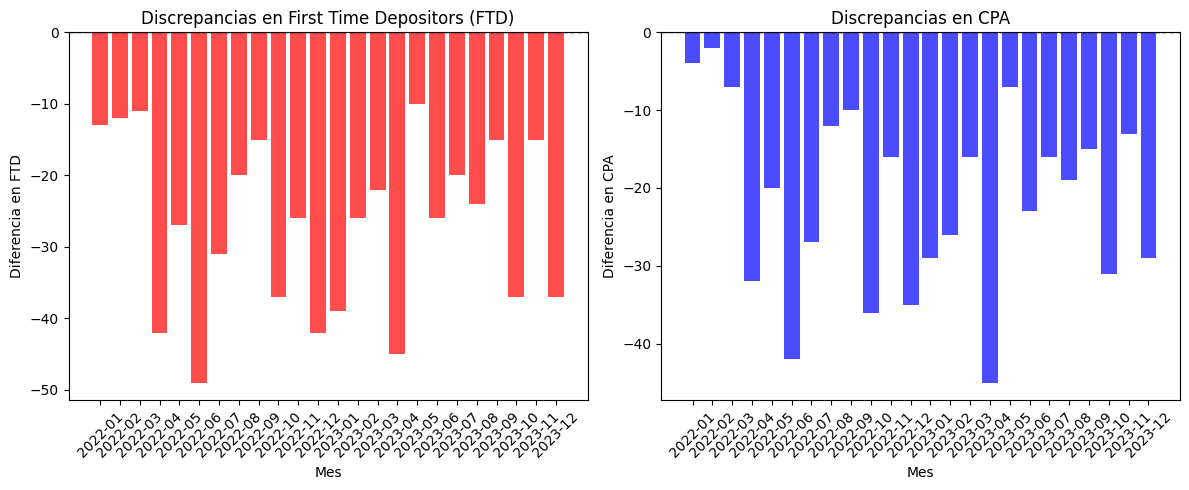

In [3]:

# Gráfico de discrepancias en FTD y CPA
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(discrepant_months["month"].astype(str), discrepant_months["ftd_discrepancy"], color='red', alpha=0.7)
plt.axhline(0, color='black', linewidth=1, linestyle='dashed')
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Diferencia en FTD")
plt.title("Discrepancias en First Time Depositors (FTD)")

plt.subplot(1, 2, 2)
plt.bar(discrepant_months["month"].astype(str), discrepant_months["cpa_discrepancy"], color='blue', alpha=0.7)
plt.axhline(0, color='black', linewidth=1, linestyle='dashed')
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Diferencia en CPA")
plt.title("Discrepancias en CPA")

plt.tight_layout()
plt.show()



## Análisis de Depósitos

Ahora analizamos el total de dinero depositado por mes, el jugador que más ha depositado y la distribución de depósitos.


In [4]:

# Convertir montos de depósito a tipo numérico
deposits["deposit_amount"] = pd.to_numeric(deposits["deposit_amount"], errors='coerce')

# Calcular total de depósitos por mes
deposits["month"] = deposits["deposit_date"].dt.to_period("M")
monthly_deposits = deposits.groupby("month")["deposit_amount"].sum().reset_index()

# Identificar al jugador que más ha depositado
top_player = deposits.groupby("player_id")["deposit_amount"].sum().idxmax()
top_player_amount = deposits.groupby("player_id")["deposit_amount"].sum().max()
top_player_name = players.loc[players["player_id"] == top_player, "name"].values[0]

print(f"Jugador con más depósitos: {top_player_name}, Total: ${top_player_amount}")

# Mostrar tabla de depósitos por mes
monthly_deposits


Jugador con más depósitos: Blake Edwards, Total: $2156.42


,month,deposit_amount
0,2022-01,175.17
1,2022-03,1610.36
2,2022-04,1363.66
3,2022-05,1286.24
4,2022-06,1772.60
5,2022-07,2837.41
6,2022-08,2221.95
7,2022-09,3575.38
8,2022-10,3210.16
9,2022-11,5550.11



## Gráficos Adicionales

1. **Histórico de dinero depositado**.
2. **Distribución de depósitos por jugador**.
3. **Comparación de fuentes de tráfico y su impacto en depósitos**.


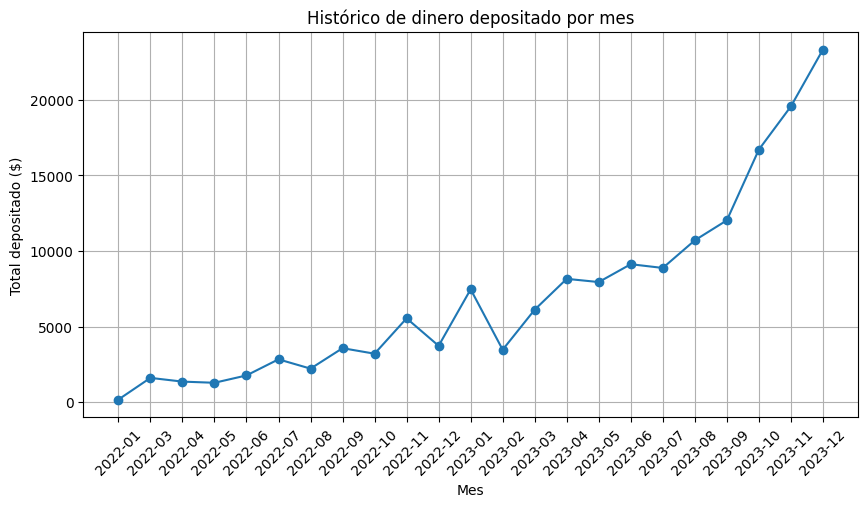

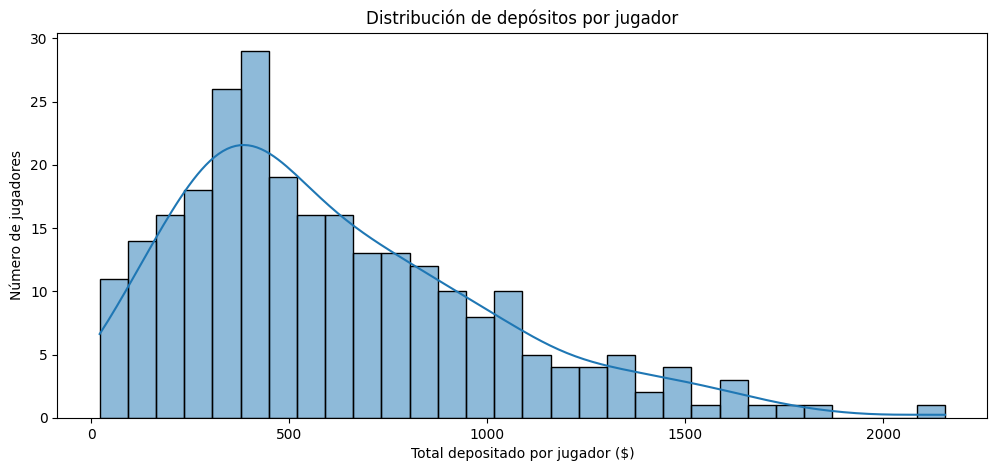

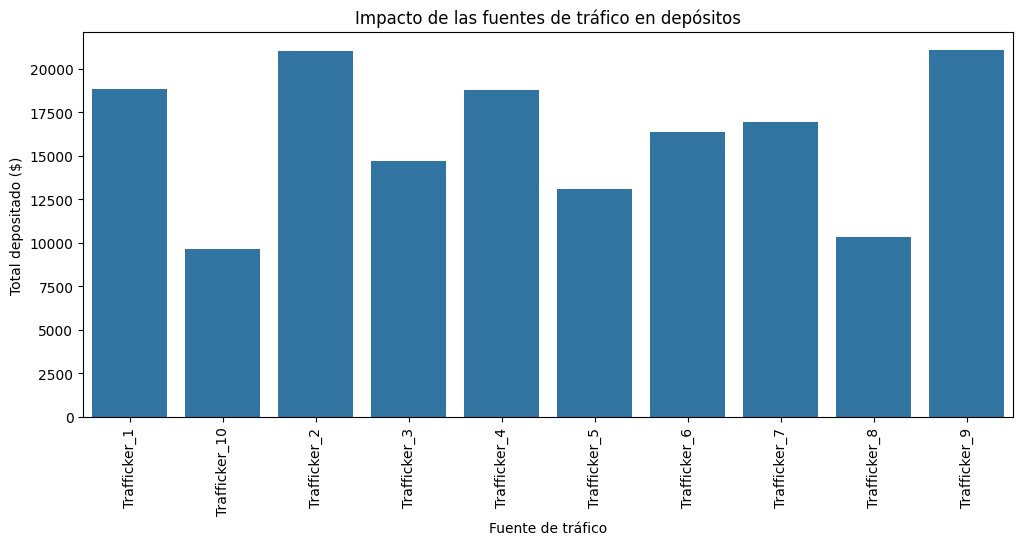

In [9]:

# Gráfico del histórico de dinero depositado
plt.figure(figsize=(10, 5))
plt.plot(monthly_deposits["month"].astype(str), monthly_deposits["deposit_amount"], marker='o', linestyle='-')
plt.xticks(rotation=45)
plt.xlabel("Mes")
plt.ylabel("Total depositado ($)")
plt.title("Histórico de dinero depositado por mes")
plt.grid(True)
plt.show()

# Gráfico de distribución de depósitos por jugador
plt.figure(figsize=(12, 5))
sns.histplot(deposits.groupby("player_id")["deposit_amount"].sum(), bins=30, kde=True)
plt.xlabel("Total depositado por jugador ($)")
plt.ylabel("Número de jugadores")
plt.title("Distribución de depósitos por jugador")
plt.show()

# Comparación de fuentes de tráfico en depósitos
merged_data = deposits.merge(traffic_sources, on="player_id", how="left")
traffic_deposit = merged_data.groupby("trafficker")["deposit_amount"].sum().reset_index()

plt.figure(figsize=(12, 5))
sns.barplot(data=traffic_deposit, x="trafficker", y="deposit_amount")
plt.xticks(rotation=90)
plt.xlabel("Fuente de tráfico")
plt.ylabel("Total depositado ($)")
plt.title("Impacto de las fuentes de tráfico en depósitos")
plt.show()